# CHEM277B Homework 7
### Trevor Oldham

#Problem 1
### (A)

Read the data from the mnist.pkl file and normalize the training set data.

In [19]:
import pandas as pd
import numpy as np

training_set, validation_set = pd.read_pickle('mnist.pkl')

#examine the shape of the training set
print(len(training_set[0]))
print(len(training_set[0][0]))
print(len(validation_set[0]))

#normalized the training data and reshape to shape (ndata, nfeatures)
normalized_train_set = tuple([z / 255 for z in training_set])
normalized_train_set_x = np.array(normalized_train_set[0])
normalized_train_set_x = normalized_train_set_x.reshape(60000, 1024)
print(normalized_train_set_x.shape)

train_set_y = np.array(training_set[1])
#print(normalized_train_set_y.shape)

#normalized the test data and reshape to shape (ndata, nfeatures)
normalized_test_set = tuple([z / 255 for z in validation_set])
normalized_test_set_x = np.array(normalized_test_set[0])
normalized_test_set_x = normalized_test_set_x.reshape(10000, 1024)
print(normalized_test_set_x.shape)

test_set_y = np.array(validation_set[1])

60000
32
10000
(60000, 1024)
(10000, 1024)


### (B), (C)

(B) Split the training set data into 3 folds with 1/3 used for validation and 2/3 used for training.

(C) Do a 3-fold validation of the data with a learning rate of 2e-3, 50 epochs, batch size 128, and plot the loss and accuracy as a function of the epoch number.

In [20]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 3),
            nn.Sigmoid(),
            nn.Linear(3, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

In [21]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [86]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform
        self.learning_rate = learning_rate


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)
        val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
        val_outputs = torch.tensor(val_outputs, dtype=torch.long)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input)
                loss_func = nn.CrossEntropyLoss()
                loss = loss_func(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate, weight_decay = 1e-5)
                    loss = loss_func(batch_predictions, batch_output)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
            epoch_loss, epoch_acc = self.evaluate(inputs, outputs)  
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss.detach().numpy())
            accuracies.append(epoch_acc)
            val_losses.append(val_loss.detach().numpy())
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=False):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """

        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.long)

        loss_func = nn.CrossEntropyLoss()
        
        pred = self.model.forward(inputs)

        losses = loss_func(pred, outputs)
        #print("pred = ", pred)
        #print("truth = " ,outputs)
        
        sum = 0
        for i in range(len(outputs)):
          if outputs[i] == torch.argmax(pred[i]):
            sum += 1
        acc = sum / len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [87]:
import matplotlib.pyplot as plt
def Kfold_validation(n, inputs, outputs):

    total_num=len(inputs)
    kf=KFold(n_splits=n,shuffle=True)


    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= inputs[train_selector]
        test_Xs=  inputs[test_selector]
        train_ys= outputs[train_selector]
        test_ys= outputs[test_selector]

        model = MLP()
        t = Trainer(model, optimizer_type='adam', learning_rate=2e-3, epoch=50, batch_size=128, input_transform=lambda x: x,)
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.666)
        
        dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=False,silent=False)

    return dictionary

In [88]:
dictionary = Kfold_validation(3, normalized_train_set_x, train_set_y)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-86-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-86-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  2%|▏         | 1/50 [00:01<00:59,  1.22s/it]

Epoch 1/50 - Loss: 2.180 - Acc: 0.347
              Val_loss: 2.181 - Val_acc: 0.342


 22%|██▏       | 11/50 [00:12<00:39,  1.01s/it]

Epoch 11/50 - Loss: 1.821 - Acc: 0.616
              Val_loss: 1.825 - Val_acc: 0.599


 42%|████▏     | 21/50 [00:22<00:29,  1.03s/it]

Epoch 21/50 - Loss: 1.741 - Acc: 0.638
              Val_loss: 1.749 - Val_acc: 0.629


 62%|██████▏   | 31/50 [00:33<00:19,  1.04s/it]

Epoch 31/50 - Loss: 1.706 - Acc: 0.630
              Val_loss: 1.716 - Val_acc: 0.621


 82%|████████▏ | 41/50 [00:44<00:10,  1.13s/it]

Epoch 41/50 - Loss: 1.689 - Acc: 0.630
              Val_loss: 1.702 - Val_acc: 0.617


func:'train'  took: 54.0464 sec


  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

Epoch 1/50 - Loss: 2.175 - Acc: 0.318
              Val_loss: 2.175 - Val_acc: 0.315


 22%|██▏       | 11/50 [00:11<00:39,  1.02s/it]

Epoch 11/50 - Loss: 1.833 - Acc: 0.549
              Val_loss: 1.837 - Val_acc: 0.539


 42%|████▏     | 21/50 [00:21<00:28,  1.00it/s]

Epoch 21/50 - Loss: 1.752 - Acc: 0.580
              Val_loss: 1.761 - Val_acc: 0.563


 62%|██████▏   | 31/50 [00:32<00:19,  1.00s/it]

Epoch 31/50 - Loss: 1.717 - Acc: 0.601
              Val_loss: 1.730 - Val_acc: 0.579


 82%|████████▏ | 41/50 [00:43<00:09,  1.04s/it]

Epoch 41/50 - Loss: 1.697 - Acc: 0.610
              Val_loss: 1.714 - Val_acc: 0.587


func:'train'  took: 53.5946 sec


  2%|▏         | 1/50 [00:01<00:49,  1.02s/it]

Epoch 1/50 - Loss: 2.182 - Acc: 0.449
              Val_loss: 2.181 - Val_acc: 0.453


 22%|██▏       | 11/50 [00:11<00:44,  1.13s/it]

Epoch 11/50 - Loss: 1.848 - Acc: 0.626
              Val_loss: 1.849 - Val_acc: 0.625


 42%|████▏     | 21/50 [00:22<00:35,  1.24s/it]

Epoch 21/50 - Loss: 1.770 - Acc: 0.644
              Val_loss: 1.773 - Val_acc: 0.636


 62%|██████▏   | 31/50 [00:32<00:18,  1.00it/s]

Epoch 31/50 - Loss: 1.735 - Acc: 0.613
              Val_loss: 1.741 - Val_acc: 0.608


 82%|████████▏ | 41/50 [00:43<00:08,  1.01it/s]

Epoch 41/50 - Loss: 1.714 - Acc: 0.608
              Val_loss: 1.722 - Val_acc: 0.601


func:'train'  took: 53.5131 sec


After running the model on three folds I saved the most recent data from the third fold and plot the validation accuracy and the validation loss on the chart below. It looks like the validation loss is approaching a horizontal asymptote but the accuracy seems to be increasing as the epochs progress. It does not seem like there is a trade off to consider when the number of epochs is 50 or lower, because it looks like the accuracy is still increasing, but since the validation loss is leveling out it may be unnecessary to train for more than 50 epochs. Also, this is only the third fold, so the most effective model that was generated could have not been saved. The model has some accuracy which is better than guessing, but it is still wrong in many cases.

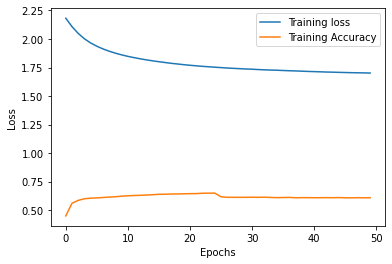

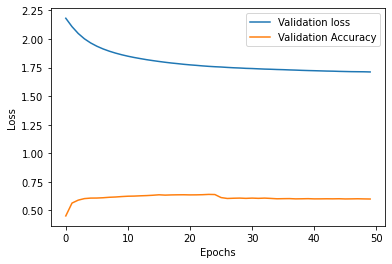

In [89]:
losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### (D)

Run the k-fold validation on a model that uses a hidden layer of 50 nodes.

In [90]:
class MLP_50(nn.Module):
    def __init__(self):
        super(MLP_50, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

In [91]:
def Kfold_validation_2(n, inputs, outputs):

    total_num=len(inputs)
    kf=KFold(n_splits=n,shuffle=True)


    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= inputs[train_selector]
        test_Xs=  inputs[test_selector]
        train_ys= outputs[train_selector]
        test_ys= outputs[test_selector]

        model = MLP_50()
        t = Trainer(model, optimizer_type='adam', learning_rate=2e-3, epoch=50, batch_size=128, input_transform=lambda x: x,)
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.666)
        
        dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=False,silent=False)

    return dictionary

In [92]:
dictionary = Kfold_validation_2(3, normalized_train_set_x, train_set_y)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-86-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-86-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  2%|▏         | 1/50 [00:01<01:02,  1.27s/it]

Epoch 1/50 - Loss: 1.698 - Acc: 0.864
              Val_loss: 1.701 - Val_acc: 0.856


 22%|██▏       | 11/50 [00:14<00:50,  1.29s/it]

Epoch 11/50 - Loss: 1.515 - Acc: 0.951
              Val_loss: 1.530 - Val_acc: 0.935


 42%|████▏     | 21/50 [00:28<00:37,  1.29s/it]

Epoch 21/50 - Loss: 1.496 - Acc: 0.968
              Val_loss: 1.517 - Val_acc: 0.945


 62%|██████▏   | 31/50 [00:41<00:24,  1.28s/it]

Epoch 31/50 - Loss: 1.486 - Acc: 0.975
              Val_loss: 1.513 - Val_acc: 0.949


 82%|████████▏ | 41/50 [00:54<00:11,  1.27s/it]

Epoch 41/50 - Loss: 1.480 - Acc: 0.980
              Val_loss: 1.512 - Val_acc: 0.951


func:'train'  took: 67.2057 sec


  2%|▏         | 1/50 [00:01<01:00,  1.23s/it]

Epoch 1/50 - Loss: 1.708 - Acc: 0.872
              Val_loss: 1.710 - Val_acc: 0.872


 22%|██▏       | 11/50 [00:14<00:48,  1.26s/it]

Epoch 11/50 - Loss: 1.516 - Acc: 0.950
              Val_loss: 1.530 - Val_acc: 0.936


 42%|████▏     | 21/50 [00:28<00:37,  1.28s/it]

Epoch 21/50 - Loss: 1.497 - Acc: 0.966
              Val_loss: 1.519 - Val_acc: 0.943


 62%|██████▏   | 31/50 [00:41<00:26,  1.41s/it]

Epoch 31/50 - Loss: 1.487 - Acc: 0.974
              Val_loss: 1.515 - Val_acc: 0.947


 82%|████████▏ | 41/50 [00:55<00:13,  1.46s/it]

Epoch 41/50 - Loss: 1.482 - Acc: 0.978
              Val_loss: 1.514 - Val_acc: 0.948


func:'train'  took: 67.3112 sec


  2%|▏         | 1/50 [00:01<01:13,  1.51s/it]

Epoch 1/50 - Loss: 1.706 - Acc: 0.874
              Val_loss: 1.706 - Val_acc: 0.878


 22%|██▏       | 11/50 [00:14<00:55,  1.42s/it]

Epoch 11/50 - Loss: 1.517 - Acc: 0.950
              Val_loss: 1.529 - Val_acc: 0.936


 42%|████▏     | 21/50 [00:28<00:39,  1.38s/it]

Epoch 21/50 - Loss: 1.497 - Acc: 0.965
              Val_loss: 1.517 - Val_acc: 0.946


 62%|██████▏   | 31/50 [00:41<00:26,  1.40s/it]

Epoch 31/50 - Loss: 1.488 - Acc: 0.973
              Val_loss: 1.512 - Val_acc: 0.950


 82%|████████▏ | 41/50 [00:55<00:13,  1.49s/it]

Epoch 41/50 - Loss: 1.482 - Acc: 0.978
              Val_loss: 1.511 - Val_acc: 0.951


func:'train'  took: 67.9454 sec


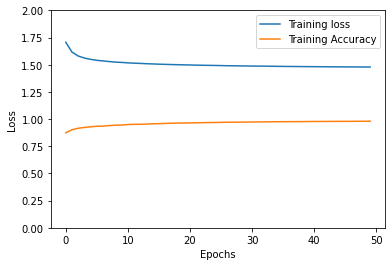

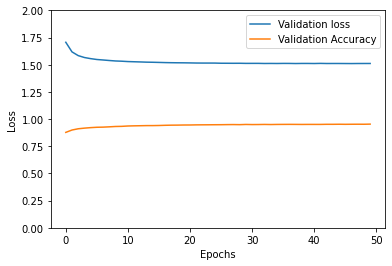

In [93]:
losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 2)
plt.ylabel('Loss')
plt.legend()

The model which implements a hidden layer of 50 nodes turns out to predict the output with high accuracy after just one epoch of training. This one step iterates through the batches and results in a trained model which is close to perfect classification of the validation data. Here the bias-variance tradeoff is to train the model a minimum amount of times because the training occurs fast. And as we add more epochs to the validation, model seems to perform close to perfect yet will not reach 100%.

# Problem 2
### (A)

Use a dropout of 15% with the ANN from 1D and compare the training and test accuracy against the previous outputs.



In [94]:

class MLP_50B(nn.Module):
    def __init__(self):
        super(MLP_50B, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Dropout(0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)


model = MLP_50B()
t = Trainer(model, optimizer_type='adam', learning_rate=2e-3, epoch=50, batch_size=128, input_transform=lambda x: x,)
train_in,val_in,train_real,val_real=train_test_split(normalized_train_set_x,train_set_y, train_size = 0.666)
        
dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=False,silent=False)


  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-86-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-86-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  2%|▏         | 1/50 [00:02<01:38,  2.02s/it]

Epoch 1/50 - Loss: 1.672 - Acc: 0.885
              Val_loss: 1.675 - Val_acc: 0.880


 22%|██▏       | 11/50 [00:23<01:23,  2.14s/it]

Epoch 11/50 - Loss: 1.519 - Acc: 0.947
              Val_loss: 1.533 - Val_acc: 0.932


 42%|████▏     | 21/50 [00:43<00:56,  1.96s/it]

Epoch 21/50 - Loss: 1.504 - Acc: 0.959
              Val_loss: 1.523 - Val_acc: 0.939


 62%|██████▏   | 31/50 [01:04<00:38,  2.02s/it]

Epoch 31/50 - Loss: 1.497 - Acc: 0.965
              Val_loss: 1.519 - Val_acc: 0.941


 82%|████████▏ | 41/50 [01:25<00:19,  2.19s/it]

Epoch 41/50 - Loss: 1.494 - Acc: 0.968
              Val_loss: 1.517 - Val_acc: 0.942


func:'train'  took: 104.3052 sec


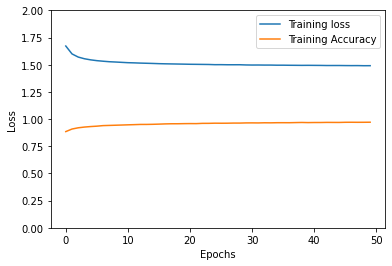

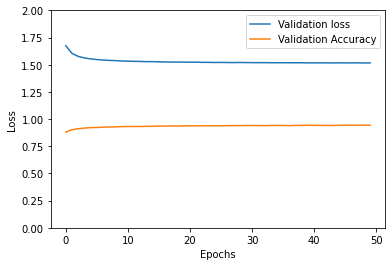

In [95]:
losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 2)
plt.ylabel('Loss')
plt.legend()

In [96]:
#feed forward into the model with the test data from MNIST and compare the results to the true y values
output = model.forward(torch.tensor(normalized_test_set_x, dtype = torch.float32))
sum = 0
for i in range(len(output)):
  if (test_set_y[i] == torch.argmax(output[i])):
    sum += 1
print(sum/len(output))

0.9509


Using a dropout before the first hidden layer has not made any significant changes in the chart other than the fact that it takes longer. I trained the model over 50 epochs just using one fold. The model predicts 93-95 percent of the classifications correctly after training over one fold of the training data.

### (B)

Use L2 Regularization on the ANN from 1D and compare the results.

In [97]:

model = MLP_50B()
t = Trainer(model, optimizer_type='adam', learning_rate=2e-3, epoch=50, batch_size=128, input_transform=lambda x: x,)
train_in,val_in,train_real,val_real=train_test_split(normalized_train_set_x,train_set_y, train_size = 0.666)
        
dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=True,silent=False)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-86-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-86-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  2%|▏         | 1/50 [00:02<01:39,  2.03s/it]

Epoch 1/50 - Loss: 1.653 - Acc: 0.875
              Val_loss: 1.654 - Val_acc: 0.874


 22%|██▏       | 11/50 [00:24<01:27,  2.24s/it]

Epoch 11/50 - Loss: 1.536 - Acc: 0.930
              Val_loss: 1.544 - Val_acc: 0.922


 42%|████▏     | 21/50 [00:44<00:58,  2.03s/it]

Epoch 21/50 - Loss: 1.530 - Acc: 0.936
              Val_loss: 1.539 - Val_acc: 0.925


 62%|██████▏   | 31/50 [01:06<00:39,  2.09s/it]

Epoch 31/50 - Loss: 1.526 - Acc: 0.939
              Val_loss: 1.536 - Val_acc: 0.927


 82%|████████▏ | 41/50 [01:28<00:19,  2.19s/it]

Epoch 41/50 - Loss: 1.528 - Acc: 0.939
              Val_loss: 1.538 - Val_acc: 0.929


func:'train'  took: 107.3078 sec


Using the L2 regularization option and dropout before the first hidden layer increases the amount of time it takes to train the model on one single training and validation fold from the original normalized data, and it performs well on the training data and validation data with very high accuracy around 93 percent.

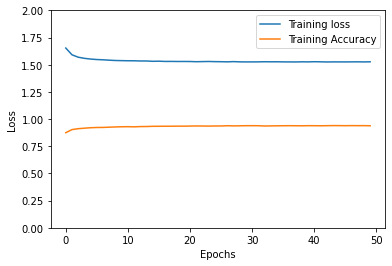

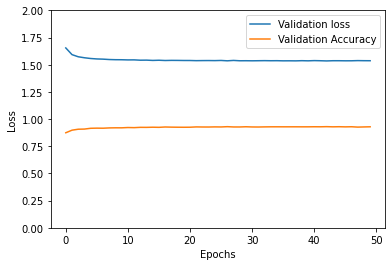

In [98]:
losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 2)
plt.ylabel('Loss')
plt.legend()

In [99]:
#feed forward into the model with the test data from MNIST and compare the results to the true y values
output = model.forward(torch.tensor(normalized_test_set_x, dtype = torch.float32))
sum = 0
for i in range(len(output)):
  if (test_set_y[i] == torch.argmax(output[i])):
    sum += 1
print(sum/len(output))

0.9353


After training the model on the normalized test data and comparing it to the true y values it shows that it has achieved around 93 percent accuracy, which is less than what the training model suggests as it performs near perfectly on the validation data during the train/test split.

### (C)

Use PCA to simplify the input features.

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
stacked_data = np.vstack((normalized_train_set_x, normalized_test_set_x))
train_and_test_pca = pca.fit_transform(stacked_data)
train_and_test_pca.shape


In [100]:
reduced_train_set = train_and_test_pca[0:60000]
reduced_test_set = train_and_test_pca[60000:70000]
print(reduced_train_set.shape)
print(reduced_test_set.shape)

(60000, 331)
(10000, 331)


The transformed input has only 331 features instead of 1024, which makes me assume that it would be faster to run but we would need to edit the model to accept inputs of size 331. If 99% of the variance is preserved in the transformation then the model should perform just as good, and even a little bit faster. Next we run the model with the reduced input features and compare against the previous ANN.

### (D)

Using the model MLP_50C with 15 percent dropout and L2 regularization disabled I train the model on the reduced set of input features and compare the accuracy on the test data to the previous ANNs.

In [101]:

class MLP_50C(nn.Module):
    def __init__(self):
        super(MLP_50C, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 50),
            nn.Dropout(0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

model = MLP_50C()
t = Trainer(model, optimizer_type='adam', learning_rate=2e-3, epoch=50, batch_size=128, input_transform=lambda x: x,)
train_in,val_in,train_real,val_real=train_test_split(reduced_train_set,train_set_y, train_size = 0.666)
        
dictionary = t.train(train_in, train_real, val_in, val_real,early_stop=False,l2=False,silent=False)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-86-5a654197e45b>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
<ipython-input-86-5a654197e45b>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)
  2%|▏         | 1/50 [00:01<01:14,  1.52s/it]

Epoch 1/50 - Loss: 1.708 - Acc: 0.887
              Val_loss: 1.710 - Val_acc: 0.882


 22%|██▏       | 11/50 [00:17<01:01,  1.57s/it]

Epoch 11/50 - Loss: 1.525 - Acc: 0.941
              Val_loss: 1.538 - Val_acc: 0.927


 42%|████▏     | 21/50 [00:32<00:42,  1.46s/it]

Epoch 21/50 - Loss: 1.509 - Acc: 0.955
              Val_loss: 1.528 - Val_acc: 0.933


 62%|██████▏   | 31/50 [00:48<00:32,  1.69s/it]

Epoch 31/50 - Loss: 1.501 - Acc: 0.961
              Val_loss: 1.524 - Val_acc: 0.938


 82%|████████▏ | 41/50 [01:03<00:14,  1.56s/it]

Epoch 41/50 - Loss: 1.498 - Acc: 0.965
              Val_loss: 1.523 - Val_acc: 0.937


func:'train'  took: 77.8303 sec


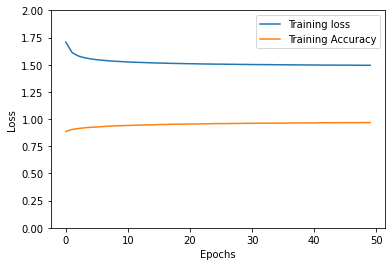

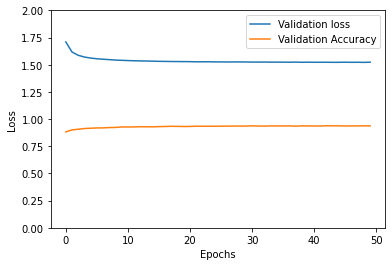

In [102]:
losses = dictionary['losses']
accuracies = dictionary['accuracies']
accuracies = np.asarray(accuracies)
losses = np.asarray(losses)
plt.figure()
plt.plot(np.arange(len(losses)),losses,label='Training loss')
plt.plot(np.arange(len(accuracies)),accuracies,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()

val_losses = dictionary['val_losses']
val_accuracies = dictionary['val_accuracies']
val_accuracies = np.asarray(val_accuracies)
val_losses = np.asarray(val_losses)
plt.figure()
plt.plot(np.arange(len(val_losses)),val_losses,label='Validation loss')
plt.plot(np.arange(len(val_accuracies)),val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 2)
plt.ylabel('Loss')
plt.legend()

In [103]:
#feed forward into the model with the test data from MNIST and compare the results to the true y values
output = model.forward(torch.tensor(reduced_test_set, dtype = torch.float32))
sum = 0
for i in range(len(output)):
  if (test_set_y[i] == torch.argmax(output[i])):
    sum += 1
print(sum/len(output))

0.9433


After running the training function with the new model it seems that the accuracy has not improved on the validation set. The training may be slightly slower judging by the curve of Validation Loss in the above charts. When I use the model to predict based on the given test data I get around 94% which is just as good as the previous ANN architecture. Using PCA in this case likely reduces the amount of memory needed but has not really improved in accuracy over the model with 1024 inputs.